In [15]:
import torch
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.vae import SpectrogramVAE

In [16]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "clean"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000", "musdb_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/sixm3zrw/checkpoints/epoch=37-step=23750.ckpt"

In [17]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [18]:
dataset = AudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    effect_audio=False,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 5389.88it/s]


Loaded 88 files for train = 66.89 hours.


In [19]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT)

In [20]:
model.eval()

SpectrogramVAE(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mu): Linear(in_features=74016, out_features=1024, bias=True)
  (log_var): Linear(in_features=74016, out_features=1024, bias=True)
  (dec_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=74016, bias=True)
    (1): ReLU()
  )
  (dec_conv1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

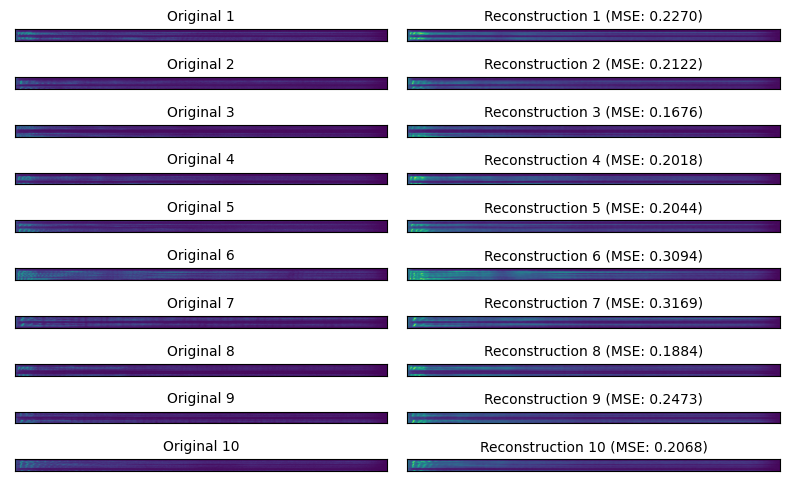

In [21]:
import torch.nn.functional as F

fig, axes = plt.subplots(NUM_EXAMPLES, 2, figsize=(8,5))

for i, spc in enumerate(loader):
    x = spc
    x_hat, _, _ = model(x)

    mse = F.mse_loss(x, x_hat)

    ax1 = axes[i, 0].imshow(x.squeeze().numpy())
    ax2 = axes[i, 1].imshow(x_hat.detach().squeeze().numpy())

    axes[i, 0].set_title(f"Original {i+1}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {i+1} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
# plt.savefig("./figures/spectrogram_reconstruction.svg")
plt.show()

In [79]:
# for batch in loader:
#     x = batch
#     plt.imshow(x.squeeze().numpy())
#     plt.title(f"x mean: {x.mean():.4}, x std: {x.std():.4}")
#     plt.show()